<a href="https://colab.research.google.com/github/karanchhabra99/FastAI/blob/main/Lesson_2%20-%20Production.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Importing Libraries

In [3]:
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [4]:
from fastbook import *
from fastai.vision.widgets import *

#### Downloading Images

In [5]:
search_images_ddg

<function fastbook.search_images_ddg(term, max_images=200)>

In [6]:
ims = search_images_ddg('grizzly bear')
len(ims)

200

In [7]:
#hide
ims = ['http://3.bp.blogspot.com/-S1scRCkI3vY/UHzV2kucsPI/AAAAAAAAA-k/YQ5UzHEm9Ss/s1600/Grizzly%2BBear%2BWildlife.jpg']

In [8]:
dest = 'images/gruzzly.jpg'
download_url(ims[0], dest)

Path('images/gruzzly.jpg')

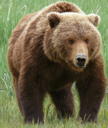

In [9]:
im = Image.open(dest)
im.to_thumb(128,128)

In [10]:
bear_types = 'grizzly', 'black', 'teddy'
path = Path('bears')

In [11]:
if not path.exists():
  path.mkdir()
  for o in bear_types:
    dest = (path/o)
    dest.mkdir(exist_ok = True)
    results = search_images_ddg(f'{o} bear')
    download_images(dest, urls = results)

In [30]:
fns = get_image_files(path)
fns

(#535) [Path('bears/black/ebead8ff-3b21-4e24-9aab-103747e36d15.jpg'),Path('bears/black/6bbc45be-5524-4044-9d7c-d510e6dee0f0.jpg'),Path('bears/black/e2cc6afd-edfe-4e85-b6d6-0bb433e5d00f.jpg'),Path('bears/black/864a239f-3a29-4ae4-936d-16ceeaa72d8e.jpg'),Path('bears/black/6f7dae3d-049e-48ce-b10e-564cc726ac43.jpg'),Path('bears/black/0282a2a1-b559-4864-8404-5783d9949487.jpg'),Path('bears/black/bbb0b8da-6306-4940-83f2-998cd254a55b.jpg'),Path('bears/black/ae787f2b-2563-4b3a-b8b6-bae0d335407d.jpg'),Path('bears/black/fdc8ee51-52bb-4c10-b853-83047634222b.jpg'),Path('bears/black/aadb6570-50cc-4526-9b08-b97ffdf4e599.jpg')...]

In [31]:
failed = verify_images(fns)
failed

(#0) []

In [32]:
failed.map(Path.unlink)

(#0) []

#### Loading Image for the model

In [15]:
bears  = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct = 0.2, seed =42),
    get_y = parent_label,
    item_tfms=Resize(128)
)

In [16]:
dls = bears.dataloaders(path)

#### Checking Data Augementation

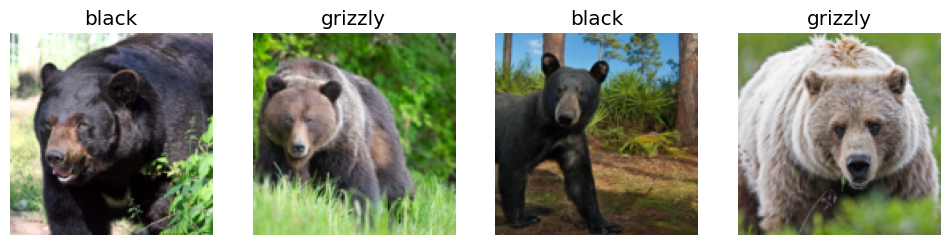

In [17]:
dls.valid.show_batch(max_n = 4, nrows =1)

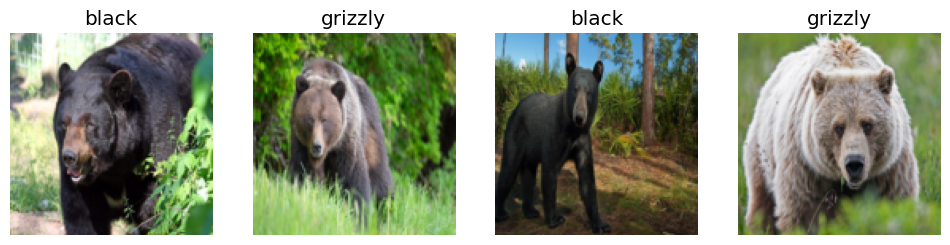

In [18]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4,nrows=1)

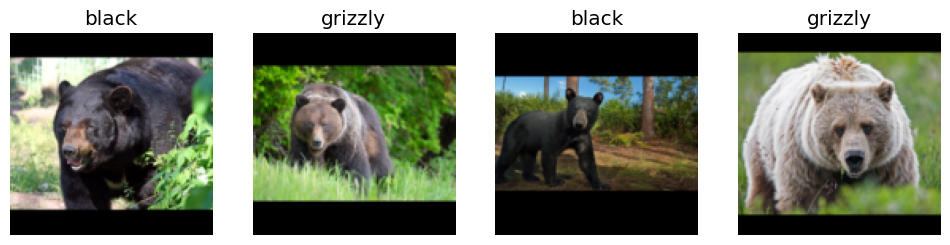

In [19]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode = 'zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows =1)

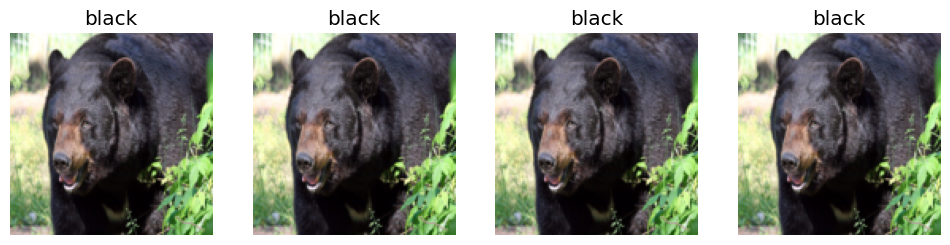

In [20]:
bears = bears.new(item_tfms= RandomResizedCrop(128, min_scale = 0.3))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1, unique=True)

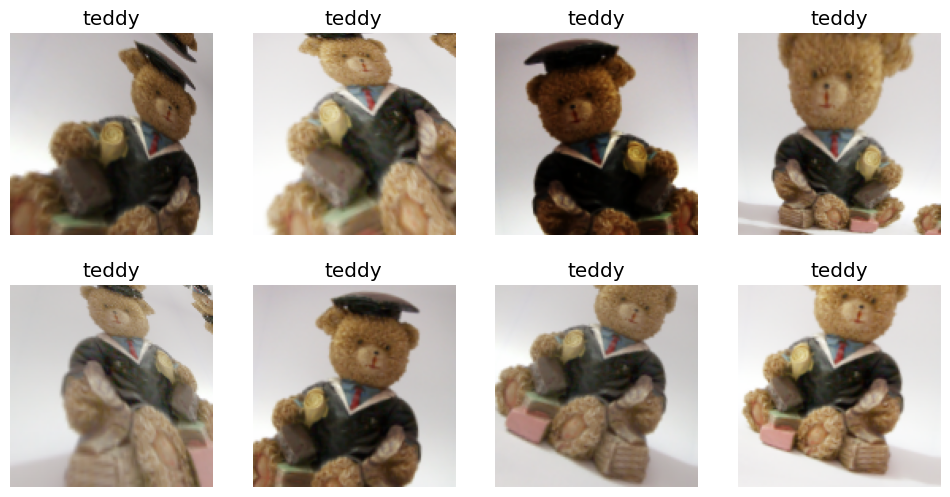

In [21]:
bears = bears.new(item_tfms = Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique = True)

#### Fitting Data Augementation to traingin data

In [22]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224,min_scale =0.5),
    batch_tfms = aug_transforms()
)
dls = bears.dataloaders(path)

#### Training the model

In [23]:
learn = vision_learner(dls, resnet18, metrics = error_rate)
learn.fine_tune(4)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,1.427052,0.125895,0.037037,00:27


epoch,train_loss,valid_loss,error_rate,time
0,0.288236,0.087126,0.037037,00:28
1,0.192932,0.080555,0.037037,00:30
2,0.164173,0.068907,0.027778,00:29
3,0.125952,0.071142,0.027778,00:29


#### Confusion Matrix

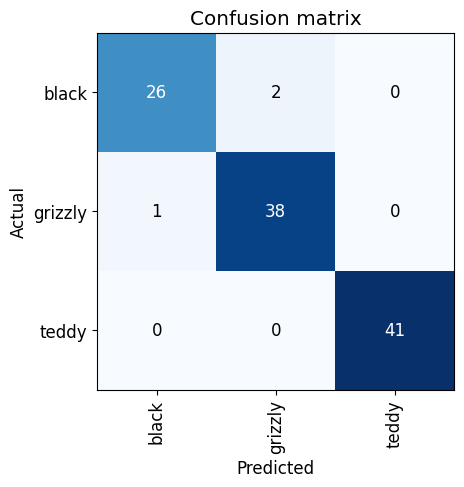

In [24]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

#### Data Clearning

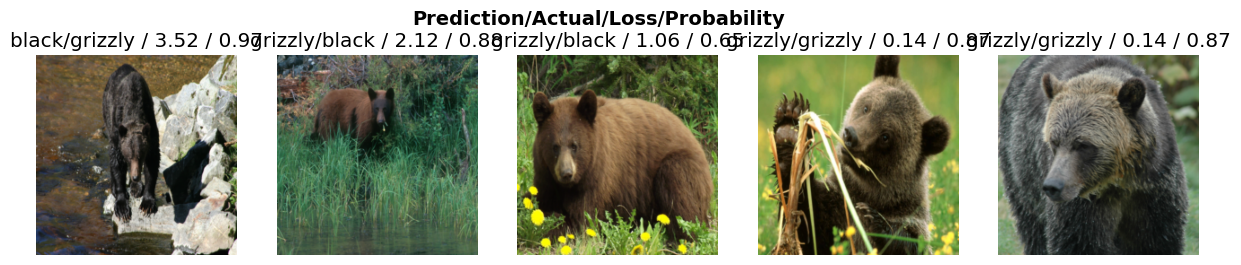

In [25]:
interp.plot_top_losses(5, nrows= 1)

In [33]:
cleaner = ImageClassifierCleaner(learn)
cleaner

FileNotFoundError: ignored

In [34]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

FileNotFoundError: ignored

In [35]:
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

#### Re-training the model after data cleaning

In [36]:
bears  = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct = 0.2, seed =42),
    get_y = parent_label,
    item_tfms=Resize(128)
)

In [37]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224,min_scale =0.5),
    batch_tfms = aug_transforms()
)
dls = bears.dataloaders(path)

In [38]:
learn = vision_learner(dls, resnet18, metrics = error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.505509,0.058668,0.028037,00:28


epoch,train_loss,valid_loss,error_rate,time
0,0.176006,0.082087,0.046729,00:28
1,0.144966,0.156483,0.037383,00:26
2,0.127744,0.137350,0.037383,00:27
3,0.099880,0.113098,0.028037,00:28


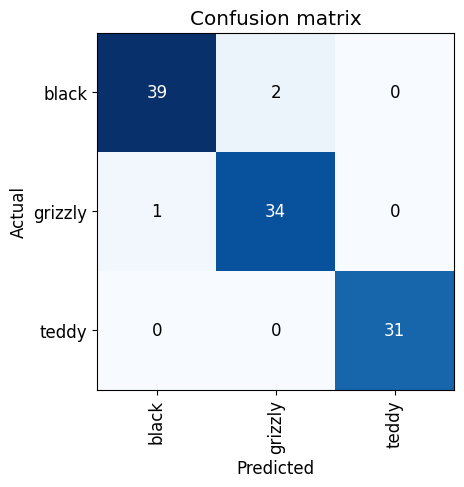

In [39]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

#### Putting model in Production

In [40]:
learn.export()